In [1]:
import numpy as np
import lqrpols
import matplotlib.pyplot as plt

#%matplotlib inline
#import numpy as np
import scipy.linalg
#import matplotlib.pylab as plt
#import seaborn as sns
import time
#sns.set_style('ticks')

Here is a link to [lqrpols.py](http://www.argmin.net/code/lqrpols.py)


In [2]:
class InstabilityException(Exception):
    def __init__(self, msg=None):
        super().__init__(msg)
        
class RankDegeneracyException(Exception):
    def __init__(self, msg=None):
        super().__init__(msg)

def _assert_matrix(M):
    assert len(M.shape) == 2
    
def _assert_square_matrix(M):
    _assert_matrix(M)
    assert M.shape[0] == M.shape[1]

def _assert_symmetric_matrix(M):
    _assert_square_matrix(M)
    assert np.allclose(M, M.T)
    
def svec(M):
    assert len(M.shape) == 2
    assert M.shape[0] == M.shape[1]
    diag = np.diag(M)
    off_diag = np.sqrt(2)*M[np.triu_indices(M.shape[0], k=1)]
    return np.hstack((diag, off_diag))

def smat(v):
    n = int((np.sqrt(1+8*v.shape[0])-1)/2)
    assert n*(n+1) == 2*v.shape[0]
    V = np.zeros((n, n))
    off_diag = v[n:]/np.sqrt(2.0)
    V[np.triu_indices(V.shape[0], k=1)] = off_diag
    V += V.T
    V[np.diag_indices(V.shape[0])] = v[:n]
    return V

def sym(M):
    return (M+M.T)/2

def spectral_radius(L):
    evs = np.linalg.eigvals(L)
    rho = max(np.abs(evs))
    return rho

def is_stable(L):
    return spectral_radius(L) < 1

def lambda_min(H):
    evs = np.linalg.eigvalsh(H)
    return min(evs)

def lambda_max(H):
    evs = np.linalg.eigvalsh(H)
    return max(evs)

class LQR_instance(object):
    
    def __init__(self, A, B, Q, R, gamma, sigma_w):
        _assert_square_matrix(A)
        self.A_ = np.array(A)
        self.state_dim_ = A.shape[0]
        _assert_matrix(B)
        assert B.shape[0] == self.state_dim_
        self.B_ = np.array(B)
        self.input_dim_ = B.shape[1]
        _assert_symmetric_matrix(Q) #assume PD
        assert Q.shape[0] == self.state_dim_
        self.Q_ = np.array(Q)
        _assert_symmetric_matrix(R) #assume PD
        assert R.shape[0] == self.input_dim_
        self.R_ = np.array(R)
        assert gamma > 0 and gamma < 1
        self.gamma_ = gamma
        self.eta_ = gamma/(1-gamma)
        assert sigma_w >= 0
        self.sigma_w_ = sigma_w
        
    def rollout_off_policy(self, T, sigma_u, x0=None, rng=None):
        """Explore with random Gaussian noise of variance sigma_u^2,
        starting with x0 given 
        
        """
        rng = np.random if rng is None else rng
        trajectory = []
        x0 = np.zeros((self.state_dim_,)) if x0 is None else x0
        xk = np.array(x0)
        for k in range(T):
            # draw exploration input
            uk = sigma_u*rng.normal(size=(self.input_dim_,))
            
            # receive reward
            rk = xk.dot(self.Q_).dot(xk) + uk.dot(self.R_).dot(uk)
            
            # take a step
            wk = self.sigma_w_*rng.normal(size=(self.state_dim_,))
            xkp1 = self.A_.dot(xk) + self.B_.dot(uk) + wk
            
            # emit (xk, uk, rk, xkp1)
            trajectory.append((xk, uk, rk, xkp1))
            
            xk = np.copy(xkp1)
        return trajectory

    def rollout(self, K, T, rng=None):
        rng = np.random if rng is None else rng
        trajectory = []
        L = self.A_ + self.B_.dot(K)
        x0 = np.zeros((self.state_dim_,))
        xk = np.array(x0)
        M = self.Q_ + K.T.dot(self.R_.dot(K))
        for k in range(T):
            # receive reward
            rk = xk.dot(M.dot(xk))

            # take a step
            wk = self.sigma_w_*rng.normal(size=(L.shape[0],))
            xkp1 = L.dot(xk) + wk

            # emit (xk, rk, xkp1)
            trajectory.append((xk, rk, xkp1))

            xk = np.copy(xkp1)
        return trajectory
        
    def phi(self, x):
        assert x.shape == (self.state_dim_,)
        return svec(np.outer(x, x) + (self.sigma_w_**2)*self.eta_*np.eye(self.state_dim_))
        
    def solve_stationary(self, K):
        """Compute the covariance of the stationary distribution of
        x_{k+1} = (A+BK) x_{k} + w_k, w_k ~ N(0, sigma^2 I)
        
        """
        L = self.A_ + self.B_.dot(K)
        P_infty = scipy.linalg.solve_discrete_lyapunov(L, self.sigma_w_*self.sigma_w_*np.eye(self.state_dim_))
        
        assert np.allclose(
            L.dot(P_infty).dot(L.T) - P_infty + self.sigma_w_*self.sigma_w_*np.eye(self.state_dim_),
            np.zeros_like(P_infty)
        )
        
        _assert_symmetric_matrix(P_infty)
        assert lambda_min(P_infty) >= -1e-10

        return P_infty
    
    def lstd_Q(self, trajectory, K):
        """Given a trajectory, use LSTD to compute 
        Q^pi(x, u)
        
        """
        
        eta = self.eta_
        IK = np.vstack((np.eye(self.state_dim_), K))
        feature_offset = (self.sigma_w_**2)*eta*IK.dot(IK.T)
        
        def phi_Q(x, u):
            xu = np.hstack((x, u))
            return svec(np.outer(xu, xu) + feature_offset)
        
        Phi = np.array([phi_Q(xk, uk) for xk, uk, _, _ in trajectory])
        Phi_plus = np.array([phi_Q(xkp1, K.dot(xkp1)) for _, _, _, xkp1 in trajectory])
        rvec = np.array([rk for _, _, rk, _ in trajectory])
        PhiTPhi = Phi.T.dot(Phi)
        Amat = PhiTPhi - self.gamma_*Phi.T.dot(Phi_plus)
    
        # Check if Phi is full column rank
        svals_Phi = np.linalg.eigvalsh(PhiTPhi)
        if min(svals_Phi) <= 1e-8:
            raise RankDegeneracyException(
                "Phi matrix is degenerate: s_min(Phi)={}".format(min(svals_Phi)))
        
        # check if Amat is full rank
        svals = scipy.linalg.svdvals(Amat)
        if min(svals) <= 1e-8:
            raise RankDegeneracyException(
                "Amat is degenerate: s_min(Amat)={}".format(min(svals)))
        
        Bmat = Phi.T.dot(rvec)
        phat = np.linalg.lstsq(Amat, Bmat)[0]
        return Phi, Phi_plus, rvec, phat
    
    def lstd(self, trajectory):
        Phi = np.array([self.phi(xk) for xk, _, _ in trajectory])
        Phi_plus = np.array([self.phi(xkp1) for _, _, xkp1 in trajectory])
        rvec = np.array([rk for _, rk, _ in trajectory])
        Amat = Phi.T.dot(Phi) - self.gamma_*Phi.T.dot(Phi_plus)
        Bmat = Phi.T.dot(rvec)
        phat = np.linalg.lstsq(Amat, Bmat)[0]
        return Phi, Phi_plus, rvec, phat
    
    def estimate_nominal(self, trajectory):
        """estimate Ahat, Bhat from the given trajectory
        
        """
        
        # number of data points by (n+p)
        BigX = np.array([np.hstack((xk, uk)) for xk, uk, _, _ in trajectory])

        # number of data points by n
        BigY = np.array([xkp1 for _, _, _, xkp1 in trajectory])
        
        soln, _, _, _ = np.linalg.lstsq(BigX, BigY) # soln = [A, B]^T
        
        Ahat_T = soln[:self.state_dim_,:]
        Bhat_T = soln[self.state_dim_:,:]
        
        Ahat, Bhat = Ahat_T.T, Bhat_T.T

        return Ahat, Bhat
    
    def solve_nominal(self, Ahat, Bhat, discount):
        return self._solve(
            np.array(Ahat),
            np.array(Bhat),
            np.array(self.Q_),
            np.array(self.R_),
            self.gamma_ if discount else 1.0)
    
    def _solve(self, A, B, Q, R, gamma):
        assert gamma >= 0 and gamma <= 1
        
        P_star = scipy.linalg.solve_discrete_are(np.sqrt(gamma)*A, B, Q, (1.0/gamma)*R)

        assert np.allclose(
            P_star,
            gamma*A.T.dot(P_star).dot(A) -
            gamma*gamma*A.T.dot(P_star).dot(B)
                .dot(scipy.linalg.solve(R + gamma*B.T.dot(P_star).dot(B), np.eye(R.shape[0])))
                .dot(B.T.dot(P_star).dot(A)) + Q
        )

        _assert_symmetric_matrix(P_star)
        assert lambda_min(P_star) >= -1e-10
        
        neg_K_star = gamma*scipy.linalg.solve(gamma*B.T.dot(P_star).dot(B) + R, np.eye(R.shape[0])).dot(B.T.dot(P_star).dot(A))
        K_star = -neg_K_star
        
        # TODO: should check controllability and observability assumptions
        L_star = A + B.dot(K_star)
        assert is_stable(np.sqrt(gamma)*L_star)
        
        return P_star, K_star
        
    def solve(self, discount):
        """Solve the problem
        
        Returns the parameterization P of an optimal value function,
        and returns an optimal policy pi(x) = K x
        
        """
        return self._solve(
            np.array(self.A_),
            np.array(self.B_),
            np.array(self.Q_),
            np.array(self.R_),
            self.gamma_ if discount else 1.0)

    def score(self, P, discount):
        """P is a parameterization of a value function
        
        """
        _assert_symmetric_matrix(P)
        if discount:
            return self.sigma_w_*self.sigma_w_/(1-self.gamma_)*np.trace(P)
        else:
            return self.sigma_w_*self.sigma_w_*np.trace(P)
        
    def solve_value_function(self, K, discount):
        """Compute the value function associated to the policy pi(x) = Kx
        
        It is given by the
        
        """
        _assert_matrix(K)
        assert K.shape == (self.input_dim_, self.state_dim_)
        
        effective_gamma = self.gamma_ if discount else 1.0
        
        L = self.A_ + self.B_.dot(K)
        # check that sqrt(gamma)*L is stable
        if not is_stable(np.sqrt(effective_gamma)*L):
            raise InstabilityException("closed loop sqrt(eff_gamma)*(A+BK) is not stable")

        # solve (sqrt(gamma) L)^T P (sqrt(gamma) L) - P + (Q+K^T R K) = 0
        P_pi = scipy.linalg.solve_discrete_lyapunov(np.sqrt(effective_gamma)*L.T, self.Q_+K.T.dot(self.R_.dot(K)))
        
        # check that this version of scipy is consistent w/ dlyap
        assert np.allclose(
            (np.sqrt(effective_gamma)*L.T).dot(P_pi).dot(np.sqrt(effective_gamma)*L) - P_pi 
            + self.Q_ + K.T.dot(self.R_).dot(K),
            np.zeros_like(P_pi)
        )

        # check that P_pi is symmetric positive definite
        _assert_symmetric_matrix(P_pi)
        assert lambda_min(P_pi) >= -1e-10

        return P_pi
    
    def greedy_update(self, P):
        """Given a parameterization of a Q function
        Q^pi(x,u) = - (x,u)^T P (x,u) - q,
        
        compute a new feedback policy by greedy maximization
        
        """
        
        _assert_symmetric_matrix(P)
        assert P.shape[0] == (self.state_dim_ + self.input_dim_)
        
        P12 = P[:self.state_dim_, self.state_dim_:]
        P22 = P[self.state_dim_:, self.state_dim_:]
        
        return -scipy.linalg.solve(P22, P12.T, sym_pos=True)
    
    def solve_q_function(self, K):
        """Compute the Q function associated to the policy pi(x) = Kx
        
        """

        _assert_matrix(K)
        assert K.shape == (self.input_dim_, self.state_dim_)
        
        L = self.A_ + self.B_.dot(K)
        # check that L is stable
        if not is_stable(np.sqrt(self.gamma_)*L):
            raise InstabilityException("sqrt(gamma)*(A+BK) is not stable")
            
        AB = np.hstack((self.A_, self.B_))
        IK = np.vstack((np.eye(self.state_dim_), K))
        
        QR = np.vstack((
            np.hstack((self.Q_, np.zeros((self.state_dim_, self.input_dim_)))),
            np.hstack((np.zeros((self.input_dim_, self.state_dim_)), self.R_))))

        P = scipy.linalg.solve_discrete_lyapunov(np.sqrt(self.gamma_)*(IK.dot(AB)).T, QR)
        _assert_symmetric_matrix(P)
        assert lambda_min(P) >= -1e-10
        return P

In [3]:
def lspi(prob, traj, K_init):
    def check_weighted_stable(K):
        if spectral_radius(np.sqrt(prob.gamma_)*(prob.A_ + prob.B_.dot(K))) >= 1:
            raise InstabilityException()
    
    K_cur = np.array(K_init)
    check_weighted_stable(K_cur)
    cur_cost = prob.score(prob.solve_value_function(K_cur, discount=True), discount=True)
    while 1:
        #print("rho(gamma*CLP)", spectral_radius(np.sqrt(gamma)*(A+B.dot(K_cur))))
        _, _, _, qhat = prob.lstd_Q(traj, K_cur)
        K_propose = prob.greedy_update(smat(qhat))
        check_weighted_stable(K_propose)
        
        # compute new
        new_cost = prob.score(prob.solve_value_function(K_propose, discount=True), discount=True)
        #print("cur_cost", cur_cost, "new_cost", new_cost)

        if np.abs(cur_cost-new_cost)/np.abs(cur_cost) <= 1e-5:
            #print("exiting")
            break

        K_cur = K_propose
        cur_cost = new_cost
        
    return K_cur, cur_cost

In [4]:
def collect_samples(prob, NT, T):
    assert T <= NT
    samples = []
    while len(samples) < NT:
        remaining = NT - len(samples)
        samples.extend(prob.rollout_off_policy(min(T, remaining), 1.0))
    return samples

In [5]:
np.random.seed(1337)

# state transition matrices for linear system: 
#     x(t+1) = A x (t) + B u(t)
A = np.array([[1,1],[0,1]])
B = np.array([[0],[1]])
d,p = B.shape

# LQR quadratic cost per state
Q = np.array([[1,0],[0,0]])

# initial condition for system
z0 = -1 # initial position
v0 = 0  # initial velocity
x0 = np.vstack((z0,v0))

R = np.array([[1.0]])

# number of time steps to simulate
T = 10

# amount of Gaussian noise in dynamics
eq_err = 1e-2

In [6]:
# N_vals = np.floor(np.linspace(1,75,num=7)).astype(int)
N_vals = [1,2,5,7,12,25,50,75]
N_trials = 10

### Bunch of matrices for storing costs
J_finite_nom = np.zeros((N_trials,len(N_vals)))
J_finite_nomK = np.zeros((N_trials,len(N_vals)))
J_finite_rs = np.zeros((N_trials,len(N_vals)))
J_finite_ur = np.zeros((N_trials,len(N_vals)))
J_finite_pg = np.zeros((N_trials,len(N_vals)))
J_inf_nom = np.zeros((N_trials,len(N_vals)))
J_inf_rs = np.zeros((N_trials,len(N_vals)))
J_inf_ur = np.zeros((N_trials,len(N_vals)))
J_inf_pg = np.zeros((N_trials,len(N_vals)))


# cost for finite time horizon, true model
J_finite_opt = lqrpols.cost_finite_model(A,B,Q,R,x0,T,A,B)

### Solve for optimal infinite time horizon LQR controller
K_opt = -lqrpols.lqr_gain(A,B,Q,R)
# cost for infinite time horizon, true model
J_inf_opt = lqrpols.cost_inf_K(A,B,Q,R,K_opt) 

# cost for zero control
baseline = lqrpols.cost_finite_K(A,B,Q,R,x0,T,np.zeros((p,d)))

# model for nominal control with 1 rollout
A_nom1,B_nom1 = lqrpols.lsqr_estimator(A,B,Q,R,x0,eq_err,1,T)
print(A_nom1)
print(B_nom1)

# cost for finite time horizon, one rollout, nominal control
one_rollout_cost = lqrpols.cost_finite_model(A,B,Q,R,x0,T,A_nom1,B_nom1)
K_nom1 = -lqrpols.lqr_gain(A_nom1,B_nom1,Q,R)
one_rollout_cost_inf = lqrpols.cost_inf_K(A,B,Q,R,K_nom1)

for N in range(len(N_vals)):
    for trial in range(N_trials):
        
        # nominal model, N x 40 to match sample budget of policy gradient
        A_nom,B_nom = lqrpols.lsqr_estimator(A,B,Q,R,x0,eq_err,N_vals[N]*40,T);
        # finite time horizon cost with nominal model
        J_finite_nom[trial,N] = lqrpols.cost_finite_model(A,B,Q,R,x0,T,A_nom,B_nom)
        # Solve for infinite time horizon nominal LQR controller
        K_nom = -lqrpols.lqr_gain(A_nom,B_nom,Q,R)
        # cost of using the infinite time horizon solution for finite time horizon
        J_finite_nomK[trial,N] = lqrpols.cost_finite_K(A,B,Q,R,x0,T,K_nom)
        # infinite time horizon cost of nominal model
        J_inf_nom[trial,N] = lqrpols.cost_inf_K(A,B,Q,R,K_nom)

        # policy gradient, batchsize 40 per iteration
        K_pg = lqrpols.policy_gradient_adam_linear_policy(A,B,Q,R,x0,eq_err,N_vals[N]*5,T)
        J_finite_pg[trial,N] = lqrpols.cost_finite_K(A,B,Q,R,x0,T,K_pg)
        J_inf_pg[trial,N] = lqrpols.cost_inf_K(A,B,Q,R,K_pg)
        
        # random search, batchsize 4, so uses 8 rollouts per iteration
        K_rs = lqrpols.random_search_linear_policy(A,B,Q,R,x0,eq_err,N_vals[N]*5,T)
        J_finite_rs[trial,N] = lqrpols.cost_finite_K(A,B,Q,R,x0,T,K_rs)
        J_inf_rs[trial,N] = lqrpols.cost_inf_K(A,B,Q,R,K_rs)

        # uniformly random sampling, N x 40 to match sample budget of policy gradient
        K_ur = lqrpols.uniform_random_linear_policy(A,B,Q,R,x0,eq_err,N_vals[N]*40,T)
        J_finite_ur[trial,N] = lqrpols.cost_finite_K(A,B,Q,R,x0,T,K_ur)
        J_inf_ur[trial,N] = lqrpols.cost_inf_K(A,B,Q,R,K_ur)
        
        # LSPI same as nominal
        

[[  1.00032885e+00   9.99484822e-01]
 [  2.11465750e-04   9.99153277e-01]]
[[-0.00174996]
 [ 0.99998723]]


In [13]:
J_finite_lspi = np.zeros((N_trials,len(N_vals)))
J_inf_lspi = np.zeros((N_trials,len(N_vals)))
K0 = np.array([[0.0,0.0]])

NT_values = np.array(N_vals)*40

lqr_prob = LQR_instance(A, B, Q, R, gamma=0.98, sigma_w=eq_err)
all_trajectories = []
for _ in range(N_trials):
    all_trajectories.append(collect_samples(lqr_prob, max(NT_values), T))

loop_start = time.time()
for idx, traj in enumerate(all_trajectories):
    for jdx, NT_value in enumerate(NT_values):
        
        iter_start = time.time()
        sample = traj[:NT_value]

        try:
            K_lspi, cost_lspi_dis = lspi(lqr_prob, sample, K0)
            # LSPI succeeded, so we can at least score the discounted
            # data_lspi_dis[idx, jdx] = cost_lspi_dis
            
            # sanity
            assert np.allclose(
                lqr_prob.score(lqr_prob.solve_value_function(K_lspi, discount=True), discount=True),
                cost_lspi_dis)
            
            # now we try to score K_lspi on the avg cost
            J_finite_lspi[idx,jdx] = lqrpols.cost_finite_K(A,B,Q,R,x0,T,K_lspi)
            J_inf_lspi[idx,jdx] = lqrpols.cost_inf_K(A,B,Q,R,K_lspi)
            
        except InstabilityException:
            # if LSPI fails, both of them will score inf
            J_finite_lspi[idx,jdx] = np.inf
            J_inf_lspi[idx,jdx] = np.inf
            
        print("done with pair (idx, jdx)", (idx, jdx), "in {} seconds".format(time.time() - iter_start))
        
print("loop took", time.time() - loop_start, "seconds")

done with pair (idx, jdx) (0, 0) in 0.019325971603393555 seconds
done with pair (idx, jdx) (0, 1) in 0.0345158576965332 seconds
done with pair (idx, jdx) (0, 2) in 0.07815289497375488 seconds
done with pair (idx, jdx) (0, 3) in 0.11578893661499023 seconds
done with pair (idx, jdx) (0, 4) in 0.20929217338562012 seconds
done with pair (idx, jdx) (0, 5) in 0.34791994094848633 seconds
done with pair (idx, jdx) (0, 6) in 0.8623569011688232 seconds
done with pair (idx, jdx) (0, 7) in 1.3002407550811768 seconds
done with pair (idx, jdx) (1, 0) in 0.026072025299072266 seconds
done with pair (idx, jdx) (1, 1) in 0.052253007888793945 seconds
done with pair (idx, jdx) (1, 2) in 0.08348584175109863 seconds
done with pair (idx, jdx) (1, 3) in 0.1408541202545166 seconds
done with pair (idx, jdx) (1, 4) in 0.1793680191040039 seconds
done with pair (idx, jdx) (1, 5) in 0.3994781970977783 seconds
done with pair (idx, jdx) (1, 6) in 0.7763919830322266 seconds
done with pair (idx, jdx) (1, 7) in 1.170487

array([  40,   80,  200,  280,  480, 1000, 2000, 3000])

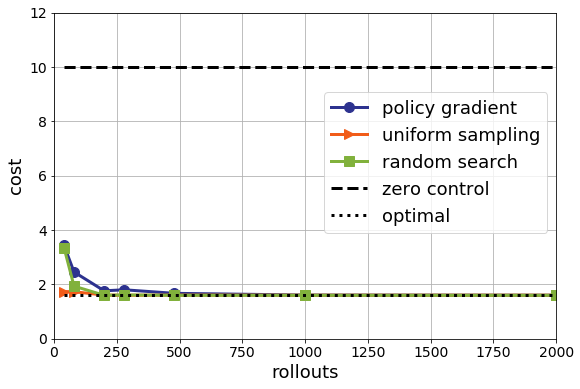

In [15]:
colors = [ '#2D328F', '#F15C19',"#81b13c","#ca49ac"]
          
label_fontsize = 18
tick_fontsize = 14
linewidth = 3
markersize = 10

tot_samples = 40*np.array(N_vals)

plt.plot(tot_samples,np.amin(J_finite_pg,axis=0),'o-',color=colors[0],linewidth=linewidth,
         markersize=markersize,label='policy gradient')

plt.plot(tot_samples,np.amin(J_finite_ur,axis=0),'>-',color=colors[1],linewidth=linewidth,
         markersize=markersize,label='uniform sampling')

plt.plot(tot_samples,np.amin(J_finite_rs,axis=0),'s-',color=colors[2],linewidth=linewidth,
         markersize=markersize,label='random search')

plt.plot([tot_samples[0],tot_samples[-1]],[baseline, baseline],color='#000000',linewidth=linewidth,
             linestyle='--',label='zero control')
plt.plot([tot_samples[0],tot_samples[-1]],[J_finite_opt, J_finite_opt],color='#000000',linewidth=linewidth,
             linestyle=':',label='optimal')

plt.axis([0,2000,0,12])

plt.xlabel('rollouts',fontsize=label_fontsize)
plt.ylabel('cost',fontsize=label_fontsize)
plt.legend(fontsize=18, bbox_to_anchor=(1.0, 0.54))
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(True)

fig = plt.gcf()
fig.set_size_inches(9, 6)

plt.show()

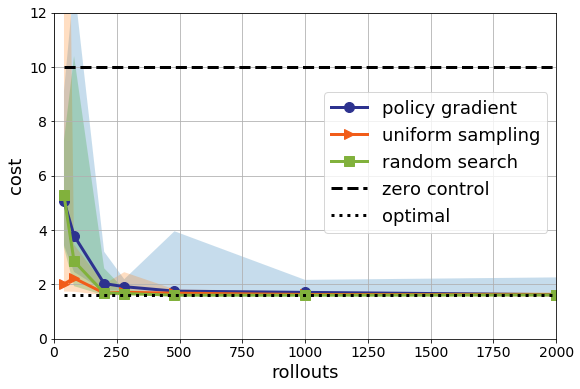

In [16]:
plt.plot(tot_samples,np.median(J_finite_pg,axis=0),'o-',color=colors[0],linewidth=linewidth,
         markersize=markersize,label='policy gradient')
plt.fill_between(tot_samples, np.amin(J_finite_pg,axis=0), np.amax(J_finite_pg,axis=0), alpha=0.25)

plt.plot(tot_samples,np.median(J_finite_ur,axis=0),'>-',color=colors[1],linewidth=linewidth,
         markersize=markersize,label='uniform sampling')
plt.fill_between(tot_samples, np.amin(J_finite_ur,axis=0), np.amax(J_finite_ur,axis=0), alpha=0.25)

plt.plot(tot_samples,np.median(J_finite_rs,axis=0),'s-',color=colors[2],linewidth=linewidth,
         markersize=markersize,label='random search')
plt.fill_between(tot_samples, np.amin(J_finite_rs,axis=0), np.amax(J_finite_rs,axis=0), alpha=0.25)


plt.plot([tot_samples[0],tot_samples[-1]],[baseline, baseline],color='#000000',linewidth=linewidth,
             linestyle='--',label='zero control')
plt.plot([tot_samples[0],tot_samples[-1]],[J_finite_opt, J_finite_opt],color='#000000',linewidth=linewidth,
             linestyle=':',label='optimal')

plt.axis([0,2000,0,12])

plt.xlabel('rollouts',fontsize=label_fontsize)
plt.ylabel('cost',fontsize=label_fontsize)
plt.legend(fontsize=18, bbox_to_anchor=(1.0, 0.54))
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(True)

fig = plt.gcf()
fig.set_size_inches(9, 6)

plt.show()

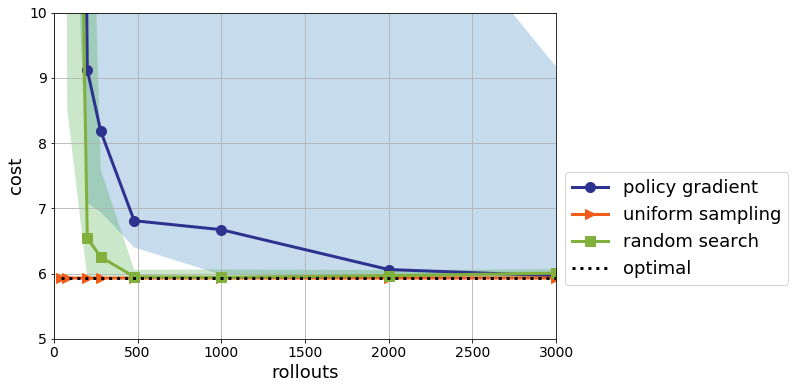

In [17]:
plt.plot(tot_samples,np.median(J_inf_pg,axis=0),'o-',color=colors[0],linewidth=linewidth,
         markersize=markersize,label='policy gradient')
plt.fill_between(tot_samples, np.amin(J_inf_pg,axis=0), np.minimum(np.amax(J_inf_pg,axis=0),15), alpha=0.25)

plt.plot(tot_samples,np.median(J_inf_lspi,axis=0),'>-',color=colors[1],linewidth=linewidth,
         markersize=markersize,label='uniform sampling')
plt.fill_between(tot_samples, np.amin(J_inf_lspi,axis=0), np.minimum(np.amax(J_inf_lspi,axis=0),15), alpha=0.25)

plt.plot(tot_samples,np.median(J_inf_rs,axis=0),'s-',color=colors[2],linewidth=linewidth,
         markersize=markersize,label='random search')
plt.fill_between(tot_samples, np.amin(J_inf_rs,axis=0), np.minimum(np.amax(J_inf_rs,axis=0),15), alpha=0.25)

plt.plot([tot_samples[0],tot_samples[-1]],[J_inf_opt, J_inf_opt],color='#000000',linewidth=linewidth,
             linestyle=':',label='optimal')

plt.axis([0,3000,5,10])

plt.xlabel('rollouts',fontsize=label_fontsize)
plt.ylabel('cost',fontsize=label_fontsize)
plt.legend(fontsize=18, bbox_to_anchor=(1.0, 0.54))
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(True)

fig = plt.gcf()
fig.set_size_inches(9, 6)

plt.show()

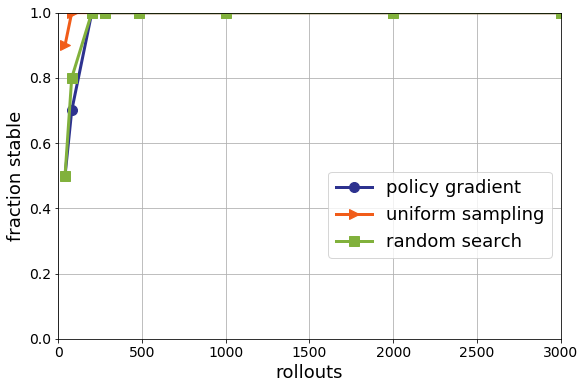

In [18]:
plt.plot(tot_samples,1-np.sum(np.isinf(J_inf_pg),axis=0)/10,'o-',color=colors[0],linewidth=linewidth,
         markersize=markersize,label='policy gradient')

plt.plot(tot_samples,1-np.sum(np.isinf(J_inf_ur),axis=0)/10,'>-',color=colors[1],linewidth=linewidth,
         markersize=markersize,label='uniform sampling')

plt.plot(tot_samples,1-np.sum(np.isinf(J_inf_rs),axis=0)/10,'s-',color=colors[2],linewidth=linewidth,
         markersize=markersize,label='random search')

plt.axis([0,3000,0,1])

plt.xlabel('rollouts',fontsize=label_fontsize)
plt.ylabel('fraction stable',fontsize=label_fontsize)
plt.legend(fontsize=18, bbox_to_anchor=(1.0, 0.54))
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(True)

fig = plt.gcf()
fig.set_size_inches(9, 6)

plt.show()

In [8]:
one_rollout_cost-J_finite_opt

3.5546858458967989e-06

In [9]:
one_rollout_cost_inf-J_inf_opt

6.2260945030701009e-06

In [22]:
np.median(J_inf_nom,axis=0)

array([ 5.93112774,  5.93112604,  5.93112602,  5.93112546,  5.93112545,
        5.93112542,  5.93112528,  5.93112527])

In [21]:
J_inf_opt

5.9311252447524279

In [24]:
np.median(J_inf_lspi,axis=0)-J_inf_opt

array([ 0.00204223,  0.00058467,  0.00040008,  0.00023329,  0.00037092,
        0.00066754,  0.00094712,  0.00096067])